# Lab 8: Neural Network


This lab material is largely self-contained. We assume that every student has already taken STAT7008 or knows some basic operations of Python. Noet that you may use Anaconda to run the .ipynb file. For the installation of Anaconda, please see https://conda.io/docs/user-guide/install/index.html.

### Purpose

In Lab 7, you will learn how to:

a. do neural netwrok (NN). 

b. do convolutional neural network (CNN). 

### Useful libraries for this Lab

a. numpy, for data array. 

b. tensorflow, for modelling.

c. matplotlib, for plotting.

d. sklearn, for data and preprocessing.

e. os, for the working directory. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

wd = os.getcwd() # Set your working directory. 
print wd

/home/renjielu/PycharmProjects/DM8017/DM_Lab8


In Lab 8, we consider to make use of MNIST. It is a data set for handwritten digits. This data consists of handwritten digit images and labels. The lable ranges from 0 to 9, meaning 10 classes. Usually, the training size of MNIST is 60,000 and the test size is 10,000. For simplicity, we take advantage of the MNIST set provided by SKlearn. Its total size is only 1,797 (see below). If one would like to try the whole data set, please see Yann Lecun's website: http://yann.lecun.com/exdb/mnist/.  

SKlearn returns the "original" target. So, before we train the models, we transform the target to the onehot target. 

We plot the first three samples. The true labels of them are 0, 1 and 2, respectively.

Note that in this lab, we suppose all students have installed the package tensorflow. 

(1797, 64)
(1797, 10)
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


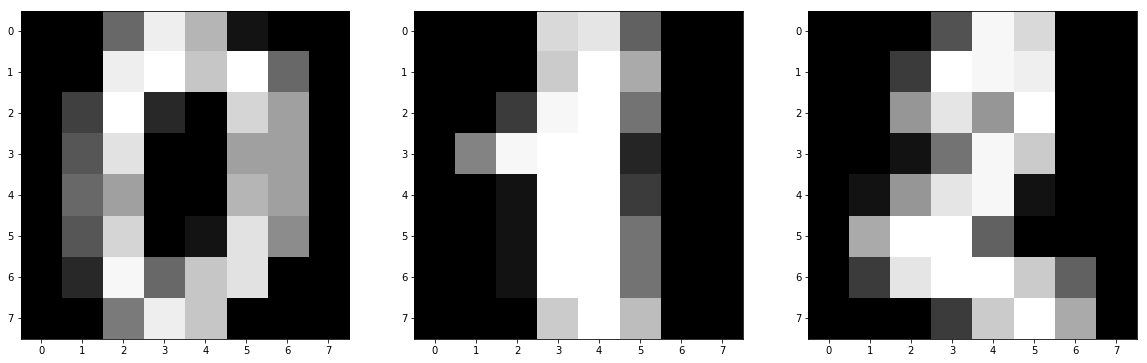

In [2]:
part_MNIST = load_digits()

X = part_MNIST.data / 255

print X.shape

onehot_encoder = OneHotEncoder(sparse=False)
label_encoder = LabelEncoder()

def onehot(data):
    tmp_data_ = np.array(data)  # np.append(np.array(data), ['-1'])
    integer_encoded = label_encoder.fit_transform(tmp_data_)
    integer_encoded = integer_encoded.reshape(-1, 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    return onehot_encoded

y = onehot(part_MNIST.target)

print y.shape
print y[:5, :]

fig = plt.figure(figsize=(20, 10))

for i in range(1, 4):

    ax = fig.add_subplot(1, 3, i)
    img = np.reshape(X[i-1, :], (8, 8))
    plt.imshow(img, cmap='Greys_r')

plt.show()

The first 1,500 data is considered to be the training data, the rest are the test data. We build a traditional neural network with two layers. Each layer has the same number of hidden units: 128. The logistic (sigmoid) function is set to be the  activation function. The output function is the softmax function, see https://en.wikipedia.org/wiki/Softmax_function for its definition. We train the model over 10 epochs. 

The following results show that the accuracy in test samples starts from 0.091, and ends at 0.747. 

In [3]:
tr_X = tf.placeholder(tf.float32, [None, X.shape[1]], name='tr_X')
tr_y = tf.placeholder(tf.float32, [None, y.shape[1]], name='tr_y')

W1 = tf.Variable(tf.random_normal([X.shape[1], 128], stddev=0.01), name='W1')
b1 = tf.Variable(tf.random_normal([128]), name='b1')

W2 = tf.Variable(tf.random_normal([128, 10], stddev=0.01), name='W2')
b2 = tf.Variable(tf.random_normal([10]), name='b2')

def model_NN():

    layer1 = tf.nn.sigmoid(tf.add(tf.matmul(tr_X, W1), b1))
    layer2 = tf.nn.sigmoid(tf.add(tf.matmul(layer1, W2), b2))
    
    return layer2


model_NN_ = model_NN()



cost = tf.reduce_mean(tf.square(tf.nn.softmax(model_NN_)-tr_y))

train_op = tf.train.AdamOptimizer().minimize(cost)

correct_pred = tf.equal(tf.argmax(model_NN_, 1), tf.argmax(tr_y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())

    for j in range(0, 10):

        for i in range(0, 1500):
            
            tmp_X = np.reshape(X[i, :], (1, -1))
            tmp_y = np.reshape(y[i, :], (1, -1))

            _, accuracy_val = sess.run([train_op, accuracy], feed_dict={tr_X: tmp_X, tr_y: tmp_y})
                        
        val_X = X[1500:, :]
        val_y = y[1500:, :]
        
        accuracy_val = sess.run([accuracy], feed_dict={tr_X: val_X, tr_y: val_y})
        
        print('Epoch {}. Avg accuracy {}'.format(j, accuracy_val[0]))



Epoch 0. Avg accuracy 0.0909090936184
Epoch 1. Avg accuracy 0.309764295816
Epoch 2. Avg accuracy 0.548821568489
Epoch 3. Avg accuracy 0.619528591633
Epoch 4. Avg accuracy 0.666666686535
Epoch 5. Avg accuracy 0.740740716457
Epoch 6. Avg accuracy 0.757575750351
Epoch 7. Avg accuracy 0.757575750351
Epoch 8. Avg accuracy 0.754208743572
Epoch 9. Avg accuracy 0.754208743572


We build a CNN as follows. The whole model architecture is suggested by BinRoot (github). We only modify it slightly since the dimension of our input is much smaller than the case they studied. Two convoluntional layers and max pooling layers are considered. The fully connected layer (the last layer) has 1024 hidden units. The accuracy for each epoch on the test samples is printed. It seems that this model structure is too complicated to handle the given data. The total number of paramters is 340,106, but the total sample size is only 1,797.

In [4]:
# the whole model graph is suggested by BinRoot (github)  

tr_X = tf.placeholder(tf.float32, [None, X.shape[1]])
tr_y = tf.placeholder(tf.float32, [None, y.shape[1]])
W1 = tf.Variable(tf.random_normal([4, 4, 1, 64]))
b1 = tf.Variable(tf.random_normal([64]))
W2 = tf.Variable(tf.random_normal([4, 4, 64, 64]))
b2 = tf.Variable(tf.random_normal([64]))

W3 = tf.Variable(tf.random_normal([2*2*64, 1024]))
b3 = tf.Variable(tf.random_normal([1024]))

W_out = tf.Variable(tf.random_normal([1024, y.shape[1]]))
b_out = tf.Variable(tf.random_normal([y.shape[1]]))

def conv_layer(x, W, b):
    conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    conv_with_b = tf.nn.bias_add(conv, b)
    conv_out = tf.nn.relu(conv_with_b)
    return conv_out


def maxpool_layer(conv, k=2):
    return tf.nn.max_pool(conv, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


def model():

    tr_X_reshaped = tf.reshape(tr_X, shape=[-1, 8, 8, 1])
    
    conv_out1 = conv_layer(tr_X_reshaped, W1, b1)
    maxpool_out1 = maxpool_layer(conv_out1)
    norm1 = tf.nn.lrn(maxpool_out1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
    conv_out2 = conv_layer(norm1, W2, b2)
    norm2 = tf.nn.lrn(conv_out2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
    maxpool_out2 = maxpool_layer(norm2)

    maxpool_reshaped = tf.reshape(maxpool_out2, [-1, W3.get_shape().as_list()[0]])
    local = tf.add(tf.matmul(maxpool_reshaped, W3), b3)
    local_out = tf.nn.relu(local)

    out = tf.add(tf.matmul(local_out, W_out), b_out)
    return out



model_op = model()

cost = tf.reduce_mean(tf.square(tf.nn.softmax(model_op)-tr_y))

train_op = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

correct_pred = tf.equal(tf.argmax(model_op, 1), tf.argmax(tr_y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())
    
    for j in range(0, 10):
        
        
        for i in range(0, 1500, 100):

            
            tmp_X = X[i:i+100, :]
            tmp_y = y[i:i+100, :]

            _, accuracy_val = sess.run([train_op, accuracy], feed_dict={tr_X: tmp_X, tr_y: tmp_y})
            
                        
        val_X = X[1500:, :]
        val_y = y[1500:, :]
        
        accuracy_val = sess.run([accuracy], feed_dict={tr_X: val_X, tr_y: val_y})
        
        print('Epoch {}. Avg accuracy {}'.format(j, accuracy_val[0]))

Epoch 0. Avg accuracy 0.101010099053
Epoch 1. Avg accuracy 0.101010099053
Epoch 2. Avg accuracy 0.101010099053
Epoch 3. Avg accuracy 0.101010099053
Epoch 4. Avg accuracy 0.101010099053
Epoch 5. Avg accuracy 0.101010099053
Epoch 6. Avg accuracy 0.101010099053
Epoch 7. Avg accuracy 0.101010099053
Epoch 8. Avg accuracy 0.101010099053
Epoch 9. Avg accuracy 0.101010099053
